# Environment

In [11]:
!pip install implicit
!pip install -U scikit-learn
!pip install numpy
!pip install matplotlib
!pip install seaborn

# Plotting Configuration

In [1]:
# Use seaborn style
import seaborn as sns
sns.set_style("darkgrid")

# MF utils

In [2]:
from scipy.sparse import csr_matrix
from implicit.bpr import BayesianPersonalizedRanking
from implicit.evaluation import train_test_split, precision_at_k

def data_loader(user_item_table):
    np.random.seed(1234)
    user_item_csr = csr_matrix(user_item_table)
    user_item_train, user_item_test = train_test_split(user_item_csr, train_percentage=0.8)
    return user_item_train, user_item_test
def recommend_all(bpr, user_item_table, user_num, top_k):
    rank_list = list() 
    score_list = list()
    for user_id in range(user_num):
        reco = bpr.recommend(user_id, user_item_table, N=top_k, filter_already_liked_items=True)
        single_rank_list = [element[0] for element in reco]
        single_score_list = [element[1] for element in reco]
        rank_list.append(single_rank_list)
        score_list.append(single_score_list)
    return rank_list, score_list
def train(user_item_table, bpr=None, trainning_iter=100):
    user_item_train, user_item_test = data_loader(user_item_table)
    np.random.seed(1234)
    if bpr:
        bpr.fit(user_item_train.T.tocsr())
    else:
        bpr = BayesianPersonalizedRanking(iterations=trainning_iter)
        bpr.fit(user_item_train.T.tocsr()) 
    return bpr
def mf_neighnorhood(u_id, mf):
    return mf.similar_users(u_id)[1][0]

# Item Attributes

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from user_model import UserModel, Popularity
from calibration import *

class ItemAttributes:
    def __init__(self):
        
        self.user_num = 100 
        self.item_num = 1000
        startup_iter = 100 - 1 # start up until all itmes include
        
        self.pseudo_usermodel = UserModel(self.user_num, startup_iter)
        self.ideal_idx = self.pseudo_usermodel.add_model()
        
        ###### start-up ######
        while self.pseudo_usermodel.startup:
            self.pseudo_usermodel.recommend([None]*self.user_num, self.ideal_idx)
            self.pseudo_usermodel.new_iter()
                
        self.ideal_item_list = self.ideal_ItemList()
        
    def ideal_ItemList(self, user_model=None):
        user_ideal_list = []
        if not user_model:
            for item_vec in self.pseudo_usermodel.selected[self.ideal_idx]:
                user_ideal_list.append(np.nonzero(item_vec)[0].tolist()) # np.nonzero returns a tuple, so use np.nonzero()[0] to get the answer
        else:
            for item_vec in user_model.selected[0]:
                user_ideal_list.append(np.nonzero(item_vec)[0].tolist()) # np.nonzero returns a tuple, so use np.nonzero()[0] to get the answer
        return user_ideal_list
    

    def thresholding(self, user_model):
        # use mean as threshold
        attributes_threshold = np.mean(user_model.item_vec, axis=0) # shape : (item_vec_dim=20,)
        
        # map from "item index" to "Item Class"
        item_mapping = {}
        for item_id in range(self.item_num):
            item_vector = user_model.item_vec[item_id]
            attributes = (np.nonzero(item_vector >= attributes_threshold)[0]).tolist() # np.nonzero returns a tuple, so use np.nonzero()[0] to get the answer
            attributes_ratio = 1. / len(attributes)
            item_attributes = {single_attribute: attributes_ratio for single_attribute in attributes}
            item_mapping[item_id] = Item(item_id, item_attributes, score=None)
        
        return item_mapping
    
    def ItemDistribution(self, item_list, item_mapping):
        # elements in item_list are all item_id, and it's size is (user_num, *),  
        # e.g ranking list : (user_num, topK)
        # e.g ideal list : (user_num, num_InteractedItems_in_ideal_case)
        
        distribution_list = []
        # item mapping & compute distribution
        for user_item_list in item_list:
            preprocess_item_list = [item_mapping[item_id] for item_id in user_item_list]        
            distribution = compute_genre_distr(preprocess_item_list)
            distribution_list.append(distribution)

        return distribution_list
        

def calibration_all(rank_list, score_list, itemId2Item, ideal_distribution_list, topk, lmbda=0.99):
    calibrated_rank_list = []
    for user_id in range(len(rank_list)):

        # transform
        user_ranking_list = [itemId2Item[item_id] for item_id in rank_list[user_id]]
        user_score_list = score_list[user_id]

        # preprocess and get ideal distribution    
        for i in range(len(user_ranking_list)):
            user_ranking_list[i].score = user_score_list[i]
        
        user_ideal_distribution = ideal_distribution_list[user_id]

        # calibration
        postprocess_user_rank_list, _ = calib_recommend(user_ranking_list, user_ideal_distribution, topn=topk, lmbda=lmbda)
        calibrated_rank_list.append(postprocess_user_rank_list)
    return calibrated_rank_list

# 1.Offline Item List

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from user_model import UserModel, Popularity
from IPython.display import clear_output

jaccard_list = list()

popularity_list = {"ideal":list(),"mf":list(),"mf_calibration":list()}

single_train = True

offline_item_list = True

for _ in range(2):

    _jaccard_list = list()

    if not single_train:
        startup_iteration = 10
        mf_training_step = 100
    else:
        startup_iteration = 30
        mf_training_step = 1000

    
    print("start up and mf training step:", startup_iteration, mf_training_step)
    
    user_num = 100
    iter_num = 100

    user_model = UserModel(user_num, 10, iter=iter_num)

    neighborhood = user_model.neighborhood()

    popularity_model = Popularity(user_num, 10 * iter_num)
    
    ideal_idx = user_model.add_model()
    popularity_idx = user_model.add_model()
    mf_idx = user_model.add_model()
    mf_calibration_idx = user_model.add_model()
    bpr = None # mf model
    bpr_calibration = None
    
    ### Calibration Config############
    pseudo_attributes = ItemAttributes()
    if offline_item_list:
        itemId2Item = pseudo_attributes.thresholding(user_model)
        ideal_distribution_list = pseudo_attributes.ItemDistribution(pseudo_attributes.ideal_item_list, itemId2Item)
    ##################################
    
    
    for iter in range(iter_num):
        clear_output(wait=True)
        # Ideal
        if iter < startup_iteration:
            user_model.recommend([[] for _ in range(user_num)], ideal_idx)
        else:
            user_model.recommend(user_model.get_ideal(ideal_idx), ideal_idx)

        ideal_jaccard = np.array([user_model.jaccard(ideal_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        # end Ideal

        # Popularity
        if iter < startup_iteration:
            feedback = user_model.recommend([[] for _ in range(user_num)], popularity_idx)
            if not single_train:
                popularity_model.feedback(feedback)
        else:
            pred = popularity_model.predict(user_model.selected[popularity_idx])
            feedback = user_model.recommend(pred, popularity_idx)
            if single_train and (iter == (startup_iteration - 1)):
                popularity_model.feedback(feedback)
            if not single_train:
                popularity_model.feedback(feedback)
                

        popularity_jaccard = np.array([user_model.jaccard(popularity_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        # end Popularity
        
        
        if not offline_item_list:
            itemId2Item = pseudo_attributes.thresholding(user_model)
            ideal_item_list = pseudo_attributes.ideal_ItemList(user_model)
            ideal_distribution_list = pseudo_attributes.ItemDistribution(ideal_item_list, itemId2Item)
        # MF & MF calibration
        if iter < startup_iteration:
            feedback = user_model.recommend([[] for _ in range(user_num)], mf_idx)
            feedback = user_model.recommend([[] for _ in range(user_num)], mf_calibration_idx)
        else:
            if not bpr:
                bpr = train(user_model.selected[mf_idx].copy(),None, mf_training_step)    
            if not bpr_calibration:
                bpr_calibration = train(user_model.selected[mf_calibration_idx].copy(), None, mf_training_step)
             
            ########## MF ##############
            ## Inference
            old_user_item_table = user_model.selected[mf_idx].copy()
            top_k = 20 # assume recommend 20 items to each user
            rank_list, _ = recommend_all(bpr, csr_matrix(old_user_item_table), user_num=100, top_k=top_k) # size of rank_list : (user_num, top_k)

            ## User Interaction
            user_model.recommend(rank_list, model_idx=mf_idx)
            new_user_item_table = user_model.selected[mf_idx].copy()

            ## Retrain Model
            if not single_train:
                bpr = train(new_user_item_table, bpr, mf_training_step)
            ###########################
            
            ######## MF Calibration #####
            ## Inference
            old_user_item_table = user_model.selected[mf_calibration_idx].copy()
            top_k = 20 # assume recommend 20 items to each user
            rank_list, score_list = recommend_all(bpr_calibration, csr_matrix(old_user_item_table), user_num=100, top_k=int(top_k*5)) # size of rank_list : (user_num, top_k)
            post_rank_list = calibration_all(rank_list, score_list, itemId2Item, ideal_distribution_list, topk=top_k)
            
            ## User Interaction
            user_model.recommend(post_rank_list, model_idx=mf_calibration_idx)
            new_user_item_table = user_model.selected[mf_calibration_idx].copy()

            ## Retrain Model
            if not single_train:
                bpr_calibration = train(new_user_item_table, bpr_calibration, mf_training_step)
            ###########################
        if bpr:
            mf_jaccard = np.array([user_model.jaccard(mf_idx, u, mf_neighnorhood(u,bpr)) for u in range(user_num)]).mean()
            ideal_jaccard2 = np.array([user_model.jaccard(ideal_idx, u, mf_neighnorhood(u,bpr)) for u in range(user_num)]).mean()
        else:
            mf_jaccard = np.array([user_model.jaccard(mf_idx, u, neighborhood[u]) for u in range(user_num)]).mean() 
            ideal_jaccard2 = np.array([user_model.jaccard(ideal_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        # end MF
        if bpr_calibration:
            mf_calibration_jaccard = np.array([user_model.jaccard(mf_calibration_idx, u, mf_neighnorhood(u,bpr_calibration)) for u in range(user_num)]).mean()
            ideal_jaccard3 = np.array([user_model.jaccard(ideal_idx, u, mf_neighnorhood(u,bpr_calibration)) for u in range(user_num)]).mean()
        else:
            mf_calibration_jaccard = np.array([user_model.jaccard(mf_calibration_idx, u, neighborhood[u]) for u in range(user_num)]).mean() 
            ideal_jaccard3 = np.array([user_model.jaccard(ideal_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        # end MF calibration
        
        
        _jaccard_list.append([popularity_jaccard - ideal_jaccard, mf_jaccard - ideal_jaccard2, mf_calibration_jaccard - ideal_jaccard3])
        user_model.new_iter()
        
    popularity_list["ideal"].append(np.sum(user_model.selected[ideal_idx],axis=0))
    popularity_list["mf"].append(np.sum(user_model.selected[mf_idx],axis=0))
    popularity_list["mf_calibration"].append(np.sum(user_model.selected[mf_calibration_idx],axis=0))
    jaccard_list.append(_jaccard_list)
    #clear_output()

# Jaccard (similar user)

## multiple training

<Figure size 432x288 with 0 Axes>

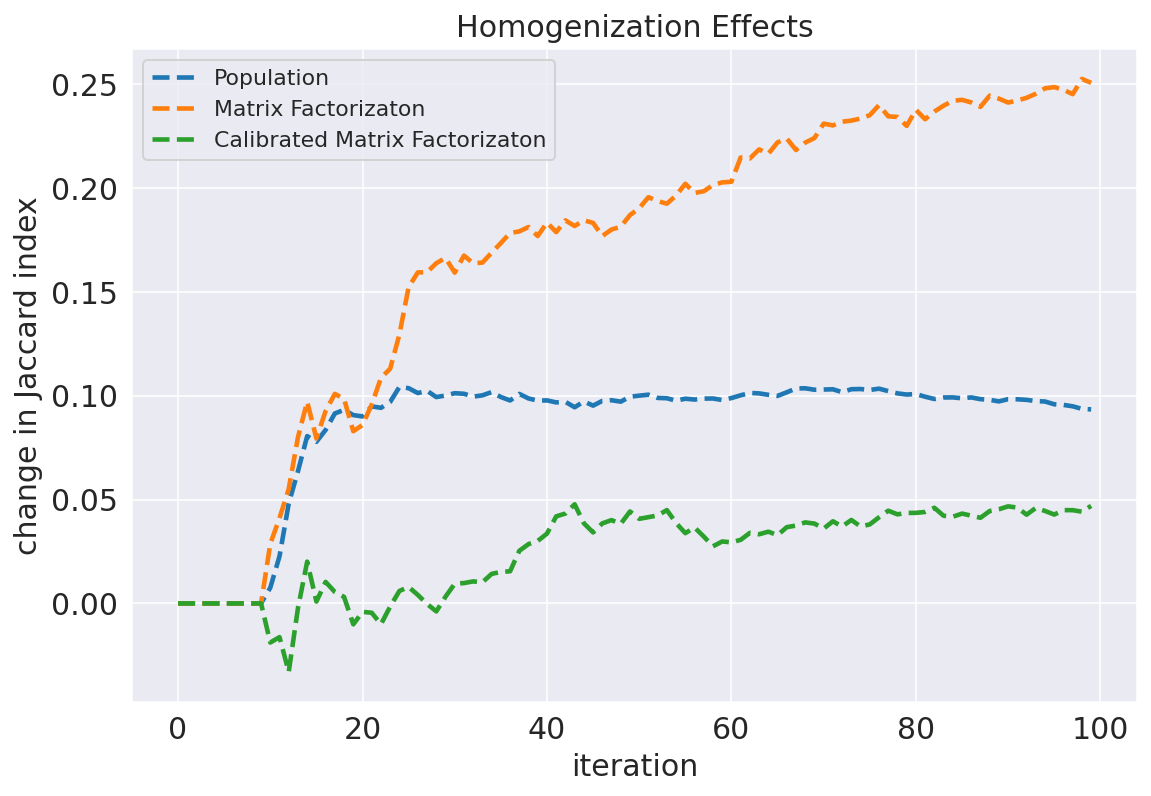

In [47]:
plt.clf()
plt.figure(figsize=(6*1.5,4*1.5))
plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,0],'--',label='Population', linewidth=2.3)
plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,1],'--',label='Matrix Factorizaton',linewidth=2.3)
plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,2],'--',label='Calibrated Matrix Factorizaton',linewidth=2.3)
plt.xlabel('iteration',fontsize=15)
plt.ylabel('change in Jaccard index',fontsize=15)
plt.title("Homogenization Effects",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 11})

## Single Training

<Figure size 432x288 with 0 Axes>

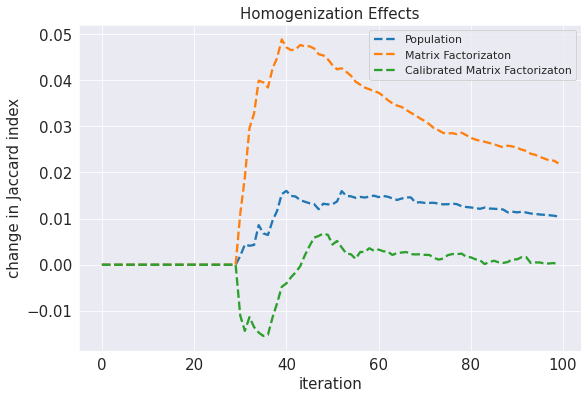

In [5]:
plt.clf()
plt.figure(figsize=(6*1.5,4*1.5))
plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,0],'--',label='Population', linewidth=2.3)
plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,1],'--',label='Matrix Factorizaton',linewidth=2.3)
plt.plot(list(range(np.array(jaccard_list).shape[1])), np.array(jaccard_list).mean(axis=0)[:,2],'--',label='Calibrated Matrix Factorizaton',linewidth=2.3)
plt.xlabel('iteration',fontsize=15)
plt.ylabel('change in Jaccard index',fontsize=15)
plt.title("Homogenization Effects",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 11})

# Popularity Distribution
## (y-axis: rated times, x-axis: items ranked by popularity) 

In [26]:
def plot_rating_popularity(popularity_list):
    def compute_gini(x, w=None):
        x = np.asarray(x)
        if w is not None:
            w = np.asarray(w)
            sorted_indices = np.argsort(x)
            sorted_x = x[sorted_indices]
            sorted_w = w[sorted_indices]
            cumw = np.cumsum(sorted_w, dtype=float)
            cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
            return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) /
                    (cumxw[-1] * cumw[-1]))
        else:
            sorted_x = np.sort(x)
            n = len(x)
            cumx = np.cumsum(sorted_x, dtype=float)
            return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    ideal_popularity = np.mean(np.array(popularity_list["ideal"]),axis=0)
    mf_popularity = np.mean(np.array(popularity_list["mf"]),axis=0)
    mf_calibration_popularity = np.mean(np.array(popularity_list["mf_calibration"]),axis=0)
    
    sort_ideal_popularity = np.sort(ideal_popularity)[::-1]
    sort_mf_popularity = np.sort(mf_popularity)[::-1]
    sort_mf_calibration_popularity = np.sort(mf_calibration_popularity)[::-1]

    plt.clf()
    plt.figure(figsize=(6*1.5,4*1.5))
    plt.plot(range(sort_ideal_popularity.shape[0]),sort_ideal_popularity,label="Ideal",linewidth=2.3)
    plt.plot(range(sort_mf_popularity.shape[0]),sort_mf_popularity,label="Matrix Factorization",linewidth=2.3)
    plt.plot(range(sort_mf_calibration_popularity.shape[0]),sort_mf_calibration_popularity,label="Calibrated Matrix Factorization",linewidth=2.3)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(prop={'size': 11})
    plt.title(r'Item popularity of 100 iterations',fontsize=15)
    plt.xlabel('Items ranked by popularity',fontsize=15)
    plt.ylabel('Number of ratings',fontsize=15)
    print("ideal gini",compute_gini(sort_ideal_popularity))
    print("mf gini",compute_gini(sort_mf_popularity))
    print("mf calibration gini",compute_gini(sort_mf_calibration_popularity))
    plt.show()


ideal gini 0.6319649999999999
mf gini 0.6286484
mf calibration gini 0.6218413


<Figure size 432x288 with 0 Axes>

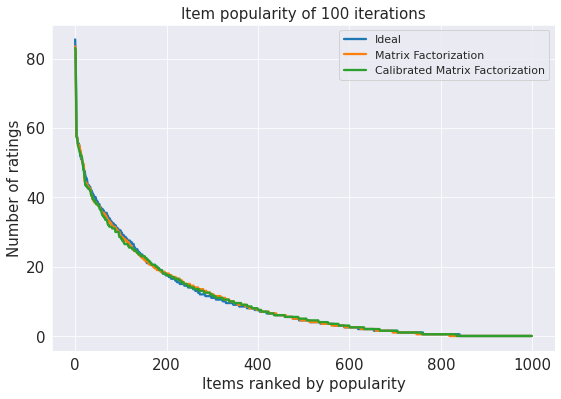

In [27]:
plot_rating_popularity(popularity_list)


# Calibration Effect on Attributes Distribution
## Take the model "mf" as example

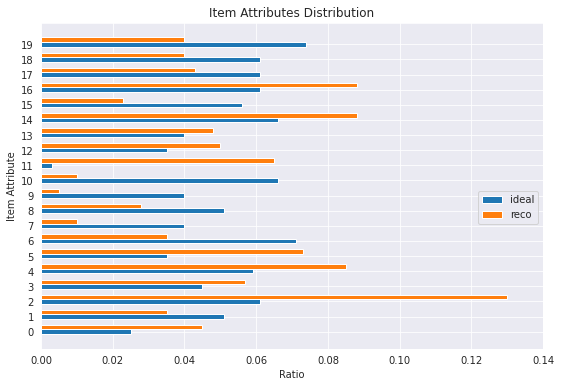

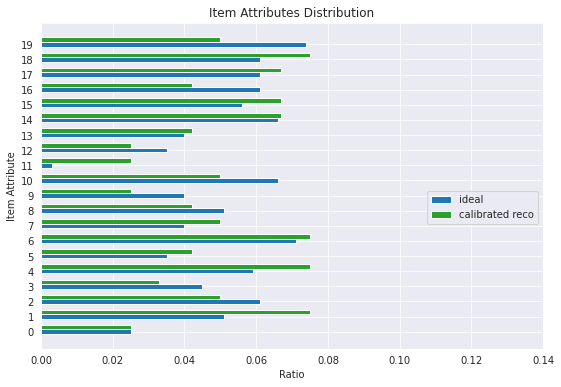

In [83]:

import pandas as pd

def two_distr_comparison_plot(interacted_distr, reco_distr, plot_label, color_label, width=0.3):
    """
    Input : two dict
    eample for single dict:
        {'Comedy': 0.062,
         'Horror': 0.225,
         'Thriller': 0.163,
         'Action': 0.087,
         'Fantasy': 0.129,
         'Adventure': 0.108,
         'Drama': 0.029,
         'Sci-Fi': 0.071,
         'Mystery': 0.046,
         'Animation': 0.037,
         'Children': 0.029,
         'Romance': 0.013}
    """
    # the value will automatically be converted to a column with the
    # column name of '0'
    interacted = pd.DataFrame.from_dict(interacted_distr, orient='index')
    reco = pd.DataFrame.from_dict(reco_distr, orient='index')
    df = interacted.join(reco, how='outer', lsuffix='_interacted')

    plt.figure(figsize=(6*1.5,4*1.5))

    n = df.shape[0]
    index = np.arange(n)
    plt.barh(index, df['0_interacted'], height=width, label=plot_label[0], color=color_label[0])
    plt.barh(index + width, df['0'], height=width, label=plot_label[1], color=color_label[1])
    plt.yticks(index, df.index)
    plt.xticks(np.array([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14]))
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.title('Item Attributes Distribution')
    plt.ylabel('Item Attribute')
    plt.xlabel('Ratio')
    plt.show()
    
def distr_comparison_plot(interacted_distr, reco_distr, calibrated_reco_distr, width=0.3):
    """
    Input : two dict
    eample for single dict:
        {'Comedy': 0.062,
         'Horror': 0.225,
         'Thriller': 0.163,
         'Action': 0.087,
         'Fantasy': 0.129,
         'Adventure': 0.108,
         'Drama': 0.029,
         'Sci-Fi': 0.071,
         'Mystery': 0.046,
         'Animation': 0.037,
         'Children': 0.029,
         'Romance': 0.013}
    """
    # the value will automatically be converted to a column with the
    # column name of '0'
    interacted = pd.DataFrame.from_dict(interacted_distr, orient='index',columns=['0_interacted'])
    reco = pd.DataFrame.from_dict(reco_distr, orient='index',columns=['0'])
    calibrated_reco = pd.DataFrame.from_dict(calibrated_reco_distr, orient='index',columns=['0_calibrated'])
    
    df = interacted.join(reco, how='outer')
    df = df.join(calibrated_reco, how='outer')
    #print(df.head())
    
    n = df.shape[0]
    index = np.arange(n)
    print(index)
    print(df['0_interacted'].values)
    plt.figure(figsize=(6*1.5,4*1.5))

    plt.barh(index, df['0_interacted'], height=width, label='ideal distr')
    plt.barh(index + width, df['0'], height=width, label='reco distr')
    plt.barh(index - width, df['0_calibrated'], height=width, label='calibrated reco distr')
    plt.yticks(index, df.index)
    plt.xticks(np.array([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14]))
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.title('Item Attributes Distribution')
    plt.ylabel('Item Attribute')
    plt.xlabel('Ratio')
    plt.show()
    

u_id = 10
topk = 20
rank_list, score_list = recommend_all(bpr, csr_matrix(user_model.selected[mf_idx]), user_num=100, top_k=int(topk*5)) # size of rank_list : (user_num, top_k)
post_rank_list = calibration_all(rank_list, score_list, itemId2Item, ideal_distribution_list, topk=topk, lmbda=0.99)
rank_distr = pseudo_attributes.ItemDistribution([rank_list[u_id]],itemId2Item)[0]
post_rank_distr = pseudo_attributes.ItemDistribution([post_rank_list[u_id]],itemId2Item)[0]
#distr_comparison_plot(ideal_distribution_list[u_id],rank_distr, post_rank_distr)
two_distr_comparison_plot(ideal_distribution_list[u_id],rank_distr, ["ideal","reco"],['tab:blue','tab:orange'])
two_distr_comparison_plot(ideal_distribution_list[u_id],post_rank_distr, ["ideal","calibrated reco"],['tab:blue','tab:green'])
